### Import Library

In [2]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

c:\Users\Admin\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Admin\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Admin\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load Data 

anh chan trung mau bg: 23854<br>
anh giay trung mau bg: 24072<br>
anh ro rang nhung nhieu curve: 24071<br>
anh cong goc giay: 23868

(-0.5, 1735.5, 1735.5, -0.5)

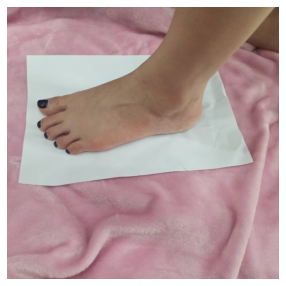

In [59]:
img = cv2.imread('data/data_foot/images/24071.jpeg')
plt.figure(figsize= [5,5])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis(False)

#### Corner detector

In [4]:
# img = cv2.imread('data/data_foot/images/24072.jpeg')
# img = cv2.resize(img,[250,250])

def detect_corner(img, blockSize=2, ksize=3, k=0.04, threshold=0.01):
    """
    img: image
    blockSize: the size of neighbourhood considered for corner detection
    ksize: parameter of Sobel derivative
    k: Harris detector free parameter in the equation.
    """ 

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst, None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>threshold*dst.max()]=[0, 0, 255]
    
    return img

# img1 = detect_corner(img)
# plt.figure(figsize=[10,10])
# plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
# plt.axis(False)

#### Thresholding by Adaptive

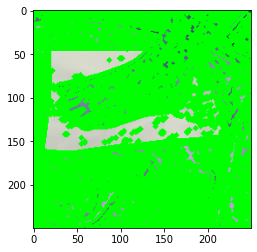

In [5]:
img = cv2.imread('data/data_foot/images/24071.jpeg')
img = cv2.resize(img,(250,250))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray,(5,5),0)
# gray = cv2.medianBlur(gray,ksize=7)

thresh = cv2.adaptiveThreshold(gray,255,
                    cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,
                    7,2
                )
# thresh = cv2.createBackgroundSubtractorKNN(= img,)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(thresh,'gray')
# plt.show()    
plt.imshow(img)

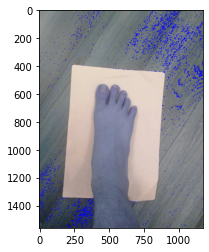

In [14]:
plt.imshow(detect_corner(img))

### Traditional approach

Just run on otsu thresholding and then watershed

(-0.5, 499.5, 499.5, -0.5)

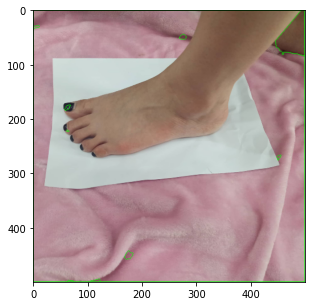

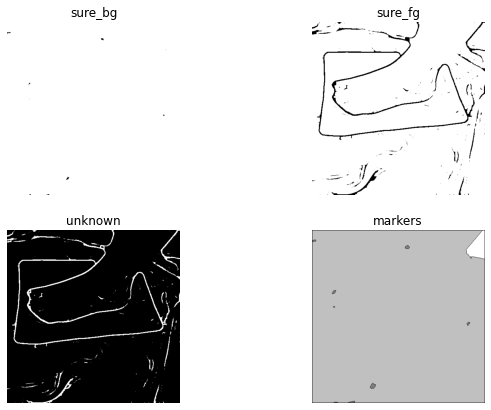

In [78]:
img = cv2.imread('data/data_foot/images/24071.jpeg')

def segment(img):
    """
    
    """
    img = cv2.resize(img,(500,500))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    gray = cv2.medianBlur(gray,ksize=21)
    thresh = cv2.adaptiveThreshold(gray,255,
                    cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,
                    7,2
                )

    # ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations = 4)
    # sure background area
    # Finding sure foreground area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0,255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers_ = markers
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img,markers)
    img[markers == -1] = [0,255,0]

    return img,sure_bg,sure_fg,unknown,markers

img1,sure_bg,sure_fg,unknown,markers = segment(img)
plt.figure(figsize=[5,5])
# plt.axis(False)
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB),'gray')
# plt.imshow(markers_)
# plt.imshow(
#     cv2.cvtColor(   
#             cv2.bitwise_and(img,img,mask=sure_bg),
#             cv2.COLOR_BGR2RGB)
#         )

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.imshow(sure_bg,'gray')
plt.title('sure_bg')
plt.axis(False)
plt.subplot(222)
plt.imshow(sure_fg,'gray')
plt.title('sure_fg')
plt.axis(False)
plt.subplot(223)
plt.imshow(unknown,'gray')
plt.title('unknown')
plt.axis(False)
plt.subplot(224)
plt.imshow(markers,'gray')
plt.title('markers')
plt.axis(False)


In [53]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect

    # print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    #cv2_imshow(crop1)

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg

def overlayImage(croppedImg, pcropedImg):


    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (255, 0, 0) # (B, G, R)

    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg

    return new_image

def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=3, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg

def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img

def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   


    paperbb = bRect

    for i in range(len(contours)):
      color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
      cv2.drawContours(drawing, cntPoly, i, color)
      #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              #(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
    
    return drawing

def edgeDetection(clusteredImage):
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, kernel=(5, 5), iterations=10)
  edged = cv2.erode(edged, kernel=(5, 5), iterations=9)
  
  edged = cv2.fastNlMeansDenoising(edged, None, 20, 7, 21) 
  return edged

def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  # print("Feet height: ", fh)
  # print("Feet Width: ", fw)

  # print("Paper height: ", ph)
  # print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh:
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh



  return ofs/10, fh, fw, ph, pw

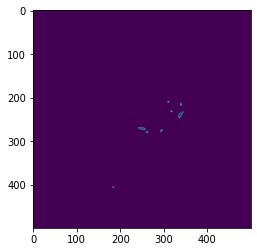

In [76]:
import numpy as np
import cv2 as cv
import random
img = cv2.imread('data/data_foot/images/24072.jpeg')
img = cv2.resize(img,(500,500))
img1,sure_bg,sure_fg,unknown,markers = segment(img)

img1 = cv2.Canny(sure_bg.astype(np.uint8), 50,200)
# contours, hierarchy = cv.findContours(img1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# # cnt = contours[-1]
# # img = cv2.drawContours(img, [cnt], 0, (0,255,0), 2)
# boundRect, contours, contours_poly, img = getBoundingBox(img1)
# img = drawCnt(boundRect[0], contours, contours_poly, img)

plt.imshow(img1)